# REINFORCE

In this notebook, we will implement REINFORCE algorithm for Discrete action spaces. The output of the network will be a probability distribution over actions.

I used some parts of the following code and the RL course at Aalto University:
https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [6]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import gym

%matplotlib inline

In [7]:
def discount_rewards(r, gamma):
    discounted_r = torch.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size(-1))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [8]:
class Policy(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.hidden = 64
        self.fc1 = torch.nn.Linear(state_space, self.hidden)
        self.out = torch.nn.Linear(self.hidden, action_space)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.out(x)
        x = F.softmax(x)
        return x

class Agent(object):
    def __init__(self, policy):
        self.train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy = policy.to(self.train_device)
        self.optimizer = torch.optim.RMSprop(policy.parameters(), lr=5e-3)
        self.gamma = 0.98
        self.states = []
        self.action_probs = []
        self.rewards = []

    def episode_finished(self, episode_number):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(self.train_device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(self.train_device).squeeze(-1)
        self.states, self.action_probs, self.rewards = [], [], []

        R = discount_rewards(rewards, self.gamma)
        R = (R - R.mean()) / (R.std() + 1e-9) #normalize discounted rewards
        loss = - (action_probs * R).mean()
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, observation, evaluation=False):
        x = torch.from_numpy(observation).float().to(self.train_device)
        action_probs = self.policy(x)

        if evaluation:
            return torch.argmax(action_probs)
        
        dist = Categorical(action_probs)
        action = dist.sample()
        act_log_prob = dist.log_prob(action)
        return action, act_log_prob

    def store_outcome(self, observation, action_prob, reward):
        self.states.append(observation)
        self.action_probs.append(action_prob)
        self.rewards.append(torch.Tensor([reward]))

# Train

[2019-11-09 13:53:11,667] Making new env: CartPole-v0
/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


action_space_dim:  2
observation_space_dim:  4
Episode 0 finished. Total reward: 37 (37 timesteps)
Episode 1 finished. Total reward: 13 (13 timesteps)
Episode 2 finished. Total reward: 11 (11 timesteps)
Episode 3 finished. Total reward: 12 (12 timesteps)
Episode 4 finished. Total reward: 8 (8 timesteps)
Episode 5 finished. Total reward: 9 (9 timesteps)
Episode 6 finished. Total reward: 10 (10 timesteps)
Episode 7 finished. Total reward: 9 (9 timesteps)
Episode 8 finished. Total reward: 10 (10 timesteps)
Episode 9 finished. Total reward: 10 (10 timesteps)
Episode 10 finished. Total reward: 10 (10 timesteps)
Episode 11 finished. Total reward: 11 (11 timesteps)
Episode 12 finished. Total reward: 17 (17 timesteps)
Episode 13 finished. Total reward: 13 (13 timesteps)
Episode 14 finished. Total reward: 22 (22 timesteps)
Episode 15 finished. Total reward: 50 (50 timesteps)
Episode 16 finished. Total reward: 19 (19 timesteps)
Episode 17 finished. Total reward: 61 (61 timesteps)
Episode 18 fini

Episode 150 finished. Total reward: 182 (182 timesteps)
Episode 151 finished. Total reward: 158 (158 timesteps)
Episode 152 finished. Total reward: 45 (45 timesteps)
Episode 153 finished. Total reward: 158 (158 timesteps)
Episode 154 finished. Total reward: 150 (150 timesteps)
Episode 155 finished. Total reward: 200 (200 timesteps)
Episode 156 finished. Total reward: 200 (200 timesteps)
Episode 157 finished. Total reward: 200 (200 timesteps)
Episode 158 finished. Total reward: 200 (200 timesteps)
Episode 159 finished. Total reward: 200 (200 timesteps)
Episode 160 finished. Total reward: 200 (200 timesteps)
Episode 161 finished. Total reward: 200 (200 timesteps)
Episode 162 finished. Total reward: 163 (163 timesteps)
Episode 163 finished. Total reward: 200 (200 timesteps)
Episode 164 finished. Total reward: 181 (181 timesteps)
Episode 165 finished. Total reward: 198 (198 timesteps)
Episode 166 finished. Total reward: 200 (200 timesteps)
Episode 167 finished. Total reward: 200 (200 times

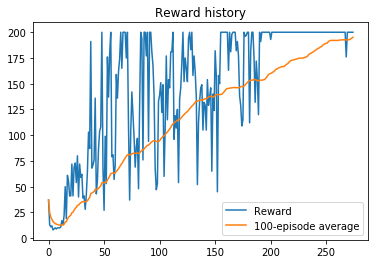

In [9]:
# Create a Gym environment
env_name = 'CartPole-v0'
train_episodes = 5000
env = gym.make(env_name)

# Get dimensionalities of actions and observations
action_space_dim = env.action_space.n
observation_space_dim = env.observation_space.shape[-1]
print('action_space_dim: ', action_space_dim)
print('observation_space_dim: ', observation_space_dim)

# Instantiate agent and its policy
policy = Policy(observation_space_dim, action_space_dim)
agent = Agent(policy)

# Arrays to keep track of rewards
reward_history, timestep_history = [], []
average_reward_history = []

# Run actual training
for episode_number in range(train_episodes):
    reward_sum, timesteps = 0, 0
    done = False
    # Reset the environment and observe the initial state
    observation = env.reset()

    # Loop until the episode is over
    while not done:
        # Get action from the agent
        action, action_probabilities = agent.get_action(observation)
        previous_observation = observation

        # Perform the action on the environment, get new state and reward
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        # Store action's outcome (so that the agent can improve its policy)
        agent.store_outcome(previous_observation, action_probabilities, reward)

        # Store total episode reward
        reward_sum += reward
        timesteps += 1


    print("Episode {} finished. Total reward: {:.3g} ({} timesteps)"
          .format(episode_number, reward_sum, timesteps))

    reward_history.append(reward_sum)
    timestep_history.append(timesteps)
    if episode_number > 100:
        avg = np.mean(reward_history[-100:])
    else:
        avg = np.mean(reward_history)
    average_reward_history.append(avg)

    agent.episode_finished(episode_number)
    
    if avg > 195:
        print(f'Converged in episode {episode_number}')
        break

plt.plot(reward_history)
plt.plot(average_reward_history)
plt.legend(["Reward", "100-episode average"])
plt.title("Reward history")
plt.show()    

# Test

In [10]:
env = gym.make(env_name)

[2019-11-09 13:53:51,180] Making new env: CartPole-v0


In [11]:
render = True
episodes = 10
test_reward, test_len = 0, 0
for ep in range(episodes):
    done = False
    observation = env.reset()
    while not done:
        # Similar to the training loop above -
        # get the action, act on the environment, save total reward
        # (evaluation=True makes the agent always return what it thinks to be
        # the best action - there is no exploration at this point)
#         print(observation)
        action = agent.get_action(observation, evaluation=True)
        observation, reward, done, info = env.step(action.detach().cpu().numpy())

        if render:
            env.render()
        test_reward += reward
        test_len += 1
print("Average test reward:", test_reward/episodes, "episode length:", test_len/episodes)


/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Average test reward: 200.0 episode length: 200.0
